# MNIST

In [24]:
%load_ext autoreload
%autoreload 2
# Import dependencies
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import torchvision
import seaborn as sns
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch
from tqdm import tqdm
from datetime import datetime
import yaml
import h5py
from copy import deepcopy
import ambiguous.models.cvae
from ambiguous.models.cvae import *
from ambiguous.dataset.dataset import partition_datasetV2, DatasetTriplet, SequenceDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
root='/network/scratch/n/nizar.islah/aemnistV4/'
seq_dataset = SequenceDataset(root, train=True, transform=transforms.ToTensor())
seq_loader = DataLoader(seq_dataset, batch_size=64, shuffle=True)
x,t = next(iter(seq_loader))
x[0].shape

60784


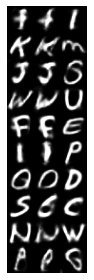

In [4]:
amnist = DatasetTriplet(root, train=True)
print(len(amnist))
amnist_loader = DataLoader(amnist, batch_size=10, shuffle=True)
(clean1, amb, clean2), label = next(iter(amnist_loader))
clean1.shape,amb.shape,clean2.shape,label[0]
fig=plt.figure()
plt.imshow(torch.cat([clean1,amb,clean2],-1).view(1,280,-1).permute(1,2,0),cmap='gray',vmin=0.5,vmax=0.7)
plt.axis('off')
plt.tight_layout()
# plt.colorbar()
fig.savefig('triplet_aemnist.png')
# imgs = torch.cat([clean1, amb, clean2], dim=-1)
# save_image(imgs, 'triplet_amnist.png', nrow=1)

In [17]:
data=[(x,t) for x,t in amnist if t[0]==0]
len(data)

KeyboardInterrupt: 

In [11]:
data[0][0].shape

torch.Size([1, 28, 28])

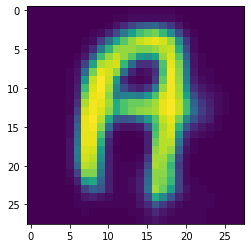

In [14]:
plt.imshow(data[12][0].permute(1,2,0))

In [6]:
root='/network/scratch/n/nizar.islah/emnist/'
amnist = DatasetTriplet(root, train=True)
print(len(amnist))
amnist_loader = DataLoader(amnist, batch_size=10, shuffle=True)
(clean1, amb, clean2), label = next(iter(amnist_loader))
clean1.shape,amb.shape,clean2.shape,label[0]
letters='abcdefghijklmnopqrstuvwxyz'

60262


b o
g q
u o
q o
e f
q p
f s
p t
c o
m p


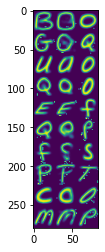

In [9]:
fig=plt.figure()
plt.imshow(torch.cat([clean1,amb,clean2],-1).view(1,280,-1).permute(1,2,0))
for i in range(10):
    print(letters[label[i][0]], letters[label[i][1]])

In [7]:
imgs = torch.cat([clean1, amb, clean2], dim=-1)
save_image(imgs, 'triplet_aemnist.png', nrow=1)

In [13]:
n_cls=10
device='cpu'
y=(torch.rand(5, 1) * 10).type(torch.LongTensor).squeeze()
onehot=torch.zeros(n_cls, n_cls).to(device).scatter_(1, torch.LongTensor(range(n_cls)).view(n_cls,1).to(device), 1).view(n_cls, n_cls)
print(y, onehot[y])

tensor([5, 9, 0, 6, 7]) tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


In [9]:
from ambiguous.models.vae import MLPVAE
from ambiguous.models.readout import Readout
from ambiguous.dataset.dataset import partition_dataset
device='cpu'
n_cls=26;img_size=28
fill = torch.zeros([n_cls, n_cls, img_size, img_size]).to(device)
for i in range(n_cls):
    fill[i, i, :, :] = 1
onehot = torch.zeros(n_cls, n_cls).to(device)
onehot = onehot.scatter_(1, torch.LongTensor(range(n_cls)).view(n_cls,1).to(device), 1).view(n_cls, n_cls, 1, 1)

def reconstruct(ccvae, images, labels, device=device):
    y_ = labels # (torch.rand(images.size(0), 1) * n_cls).type(torch.LongTensor).squeeze().to(device)
    y = onehot[y_]
    labels_fill_ = fill[labels]
    rec_x, _, _ = ccvae((images, labels_fill_, y))
    return rec_x
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.rot90(1,[2,1]).flip(2)
])
# dataset = datasets.EMNIST(root='./', download=False, split='byclass', train=True, transform=transform)
# new_dataset = partition_dataset(dataset, range(10, 36))
# train_set, val_set = torch.utils.data.random_split(new_dataset, [round(0.8*len(new_dataset)), round(0.2*len(new_dataset))])
# test_set = datasets.EMNIST(root='./', download=False, split='byclass', train=False, transform=transform)
# batch_size=64
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
vae = MLPVAE(latent_dim=10, input_img_size=28).to(device)
vae.load_state_dict(torch.load('/network/scratch/n/nizar.islah/mlp_vae_emnist.pth', map_location='cpu'))
readout = Readout(latent_dim=10, h=512, n_classes=n_cls).to(device)
readout.load_state_dict(torch.load(root+'/network/scratch/n/nizar.islah/readout_emnist.pth', map_location='cpu'))
vae.eval(); readout.eval()
train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
criterion = nn.CrossEntropyLoss()
print("Loaded vae and readout checkpoints.")
for _, (images, labels) in enumerate(val_loader):
    images, labels = images.to(device), labels.to(device)
    rec_x = reconstruct(ccvae, images, labels)
    loss, pred = loss_readout_OG(readout, vae, rec_x, labels, criterion)
    val_loss += loss/batch_size
    val_acc += (torch.argmax(pred,1)==labels).float().sum()

val_acc /= (batch_size*len(val_loader))
print(f"Epoch:{i+1} \t Val Loss:{val_loss/len(val_loader):.3f} \t Val Acc:{val_acc:.3f}")


FileNotFoundError: [Errno 2] No such file or directory: '/network/scratch/n/nizar.islah/amnistV2/mlp_vae_emnist.pth'

In [7]:
ccvae=Conv_CVAE(latent_dim=10,n_cls=26)
ccvae.load_state_dict(torch.load('/network/scratch/n/nizar.islah/ccvae_emnist.pth', map_location='cpu'))
ccvae

Conv_CVAE(
  (encoder): Sequential(
    (0): CatConv(
      (conv1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (conv2): Sequential(
        (0): Conv2d(26, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): 

In [22]:
n_cls=10
latent_dim=10
device='cpu'
onehot = torch.zeros(n_cls, n_cls).scatter_(1, torch.LongTensor(range(n_cls)).view(n_cls,1), 1).view(n_cls, n_cls, 1, 1)
def next_iter(batch_size):
    z = torch.randn(batch_size, latent_dim).to(device)*2
    t = (torch.rand(batch_size, 1) * n_cls).type(torch.LongTensor).squeeze(1)
    y = onehot[t].to(device)
    x = ccvae.decode((z, y))
    return x.squeeze(0), t.squeeze(0)
x.shape

torch.Size([32, 1, 28, 28])

tensor(0.9984, grad_fn=<MaxBackward1>) tensor(-0.0594, grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


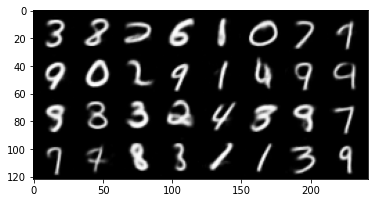

In [26]:
x,t=next_iter(32)
print(x.max(),x.min())
grid = torchvision.utils.make_grid(x)
plt.imshow(grid.permute(1,2,0))

In [12]:
_,mu1,_,_ = vae(torch.from_numpy(example[:,:,:28]).float())
_,mu2,_,_ = vae(torch.from_numpy(example[:,:,28:56]).float())
_,mu3,_,_ = vae(torch.from_numpy(example[:,:,56:]).float())
print(mu1.shape)
def prob(x): 
    return torch.softmax(readout(x),dim=1)
p1,p2,p3 = prob(mu1),prob(mu2),prob(mu3)
p1,p2,p3

torch.Size([1, 10])


(tensor([[1.4749e-06, 4.3876e-06, 4.0042e-05, 2.1521e-05, 3.6139e-06, 6.5240e-04,
          1.3920e-01, 3.7184e-07, 8.6007e-01, 2.6223e-06]],
        grad_fn=<SoftmaxBackward0>),
 tensor([[1.4048e-06, 4.5335e-06, 3.9356e-05, 2.1454e-05, 3.5447e-06, 6.0748e-04,
          1.3129e-01, 3.7760e-07, 8.6803e-01, 2.4880e-06]],
        grad_fn=<SoftmaxBackward0>),
 tensor([[1.2512e-06, 4.8015e-06, 3.9227e-05, 2.1467e-05, 3.4535e-06, 5.4697e-04,
          1.2185e-01, 3.9048e-07, 8.7753e-01, 2.3152e-06]],
        grad_fn=<SoftmaxBackward0>))

In [2]:
TRAIN_CVAE = True
LOCAL_CKPT = False

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Seed for reproducibility
torch.manual_seed(42)
print(device)
root='/home/mila/n/nizar.islah/expectation-clamp/'

cpu


In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST(root=root, download=True, train=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [round(0.8*len(dataset)), round(0.2*len(dataset))])
test_set = datasets.MNIST(root=root, download=True, train=False, transform=transform)
# Dataloaders
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=2)

In [4]:
s = range(100)
t = tqdm(total=len(s))
for x in s:
    t.update()
t.refresh()  # force print final state

t.reset()  # reuse bar
for x in s:
    t.update()
t.close()  # close the bar permanently

100%|██████████| 100/100 [00:00<00:00, 159783.01it/s]


In [6]:
x,t=next(iter(train_loader))
torchvision.utils.save_image(x, 'image.png', nrow=8)

In [7]:
n_cls=10
img_size=28
lr=1e-3
num_epochs=50
latent_dim = 10

onehot = torch.zeros(n_cls, n_cls).to(device)
onehot = onehot.scatter_(1, torch.LongTensor(range(n_cls)).view(n_cls,1).to(device), 1).view(n_cls, n_cls, 1, 1)
fill = torch.zeros([n_cls, n_cls, img_size, img_size]).to(device)
for i in range(n_cls):
    fill[i, i, :, :] = 1

if TRAIN_CVAE:
    model = Conv_CVAE(
    latent_dim = latent_dim,
        n_cls=n_cls
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss(reduction='sum')
    n_train = len(train_loader)
    n_val = len(val_loader)
    for i in tqdm(range(num_epochs)):
        running_loss = 0
        for idx, (images, labels) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            labels_fill_ = fill[labels]
            y_ = (torch.rand(images.size(0), 1) * n_cls).type(torch.LongTensor).squeeze().to(device)
            y_label_ = onehot[y_]
            rec, mu, logvar = model((images, labels_fill_, y_label_))
            loss_dict = model.loss_function(rec, images, mu, logvar)
            running_loss += loss_dict['loss'].item()/batch_size
            optimizer.zero_grad()
            loss_dict['loss'].backward()
            optimizer.step()
            # wandb.log(loss_dict)
        val_loss = 0
        for _, (images, labels) in tqdm(enumerate(val_loader)):
            with torch.no_grad():
                images = images.to(device)
                labels = labels.to(device)
                labels_fill_ = fill[labels]
                y_ = (torch.rand(images.size(0), 1) * n_cls).type(torch.LongTensor).squeeze()
                y_label_ = onehot[y_]
                rec, mu, logvar = model((images, labels_fill_, y_label_))
                torchvision.utils.save_image(rec, "reconstruction_valid.pdf")
                loss_dict = model.loss_function(rec, images, mu, logvar)
                val_loss += loss_dict['loss'].item()/batch_size
                loss_dict = {'loss_val':loss_dict['loss'], 'kld_val':loss_dict['kld'], 'rec_val':loss_dict['rec']}
                # wandb.log(loss_dict)
        torch.save(model, 'conv_cvae_mnist.pth')
        print(f"Epoch: {i+1} \t Train Loss: {running_loss:.2f} \t Val Loss: {val_loss:.2f}")
    
else:
    if LOCAL_CKPT:
        ckpt_path = ""
        ckpt = torch.load(ckpt_path)
    else:
        # run = wandb.init()
        # artifact = run.use_artifact('team-nizar/EMNIST_CVAE/model-pkia9rhl:v29', type='model')
        # artifact_dir = artifact.download()
        ckpt_path = ""
        ckpt = torch.load(ckpt_path)
        model = EMNIST_CVAE(latent_dim, enc_layers, dec_layers, n_classes=26, conditional=True).to(device)
        model.load_state_dict(ckpt['state_dict'])
    
model.eval()

10 16


7it [00:43,  6.19s/it][00:00<?, ?it/s]
  0%|          | 0/50 [00:44<?, ?it/s]


KeyboardInterrupt: 

In [8]:
model.eval()
for _, (images, labels) in enumerate(val_loader):
    with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        labels_fill_ = fill[labels]
        y_ = (torch.rand(images.size(0), 1) * n_cls).type(torch.LongTensor).squeeze()
        y_label_ = onehot[y_]
        rec, mu, logvar = model((images, labels_fill_, y_label_))
    break

torchvision.utils.save_image(rec, "example.pdf")

In [10]:
for _, (images, labels) in enumerate(val_loader):
    with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        labels_fill_ = fill[labels]
        y_ = (torch.rand(images.size(0), 2) * n_cls).type(torch.LongTensor).squeeze()
        y_label_ = onehot[y_]
        rec, mu, logvar = model((images, labels_fill_, y_label_))
    break
    
torchvision.utils.save_image(rec, "example_ambi.pdf")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.